# **AegisLens** : EasyOCR Implementation For License Plate

---
## Background

this is part of the AegisLens project. this notebook show and explain the implementation of EasyOCR.

The aim for this implementation is to detect the lincense plate from a picture taken from the YOLO model. The YOLO model will predict 5 different classes. one of them is the license plate.

As our project aim for indonesian region, the license plate format will follow the indonesian format

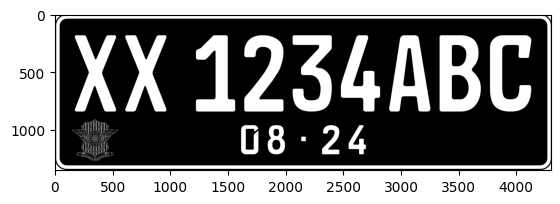

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(mpimg.imread('References/2019_indonesian_plate.png'))

This is the standard format for indonesian license plate,
- the top section is the unique identifier for each car, with the rules of :
    - First 1-2 letter referencing area codes
    - Number between 1-9999
    - Followed with 1-3 letter that might be unique or referencing special codes
- The bottom section reference the plate expiry date, wtih the format of MM . YY
- The plate is color coded with either black background or white background for privately owned car, yellow background for commercial vehicles, etc.
for more reference about indonesian license plate, [can be checked here.](https://en.wikipedia.org/wiki/Vehicle_registration_plates_of_Indonesia)


---
## Formal Description of the Algorithm

The main challenge for this project is to implement a real-time detection (frame by frame) with YOLO and OCR implemented. not annotating an existing video by reading the video once, predicting, and annotating after.

Therefore the model need to work together with the YOLO, with YOLO predicting the bounding box for the license plate, pass it to EasyOCR using OpenCV.

The main concern is the bounding box given by the yolo have both the unique identifier and the expiry date, and easy ocr will read both of them as a single line. Therefore the picture need to be separated to make sure the OCR wont read both of them.

After several testing the ratio for the picture will be
- License Plate - 70% of the picture from the top
- Expiry Date - 45% of the picture from the bottom

To solve this problem there will be 2 step for the OCR.
1. YOLO detect the license plate and pass the picture to OpenCV to be cropped.
2. OpenCV crop the picture according to the bounding box
3. OpenCV separate the picture with the defined ratio
4. Passing both picture to the OCR
5. OCR return value, that will be shown in the actual predictor/application

---
## Implementation

The code here is the early implementation, it still work as the model will just 'annotate' the imported video. this will be the base code for the prediction later on

### Libraries

In [1]:
import cv2
from ultralytics import YOLO
import easyocr
import numpy as np
import re
import matplotlib.pyplot as plt

### Defining Functions

In [10]:
# --- HELPER FUNCTIONS ---

def preprocess_expiry_crop(crop):
    if crop is None or crop.shape[0] < 5 or crop.shape[1] < 10:
        return None
    
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    
    scale = max(2.0, 50.0 / gray.shape[0])
    resized = cv2.resize(gray, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    
    _, thresh = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return thresh

def extract_and_validate_date(text):
    if not text:
        return "UNKNOWN"

    digits = re.sub(r'\D', '', text)
    
    if len(digits) == 4:
        month_str, year_str = digits[:2], digits[2:]
        try:
            if 1 <= int(month_str) <= 12:
                return f"{month_str}.{year_str}"
        except ValueError:
            pass 
            
    return "INCORRECT LENGTH "

def show_image(image, title="Image"):
    if image is None:
        print("No image to display")
        return

    plt.figure(figsize=(6, 4))
    if len(image.shape) == 2: 
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


### Model Initialization

In [32]:
model = YOLO('latest.pt')

reader = easyocr.Reader(['en'], gpu=True) 

video_path = 'test.MOV'
cap = cv2.VideoCapture(video_path)

### Video Initialization

In [33]:
# --- VIDEO WRITER SETUP ---
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

output_path = 'output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for .mp4 file
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

### OCR Implementation

**This code part detect 100% plate**


0: 384x640 1 Car, 1 LicensePlate, 22.0ms
Speed: 5.9ms preprocess, 22.0ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Car, 1 LicensePlate, 27.2ms
Speed: 3.3ms preprocess, 27.2ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Car, 1 LicensePlate, 21.9ms
Speed: 3.5ms preprocess, 21.9ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Car, 1 LicensePlate, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Car, 1 LicensePlate, 11.5ms
Speed: 3.2ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Car, 1 LicensePlate, 13.7ms
Speed: 2.5ms preprocess, 13.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Car, 1 LicensePlate, 10.2ms
Speed: 2.6ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Car, 1 Licens

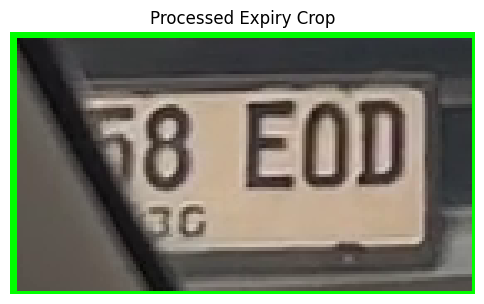

expiration date - 58EOD)3C


In [ ]:
"""while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, stream=True)

    for result in results:
        boxes = result.boxes
        for box in boxes:
            if int(box.cls[0]) == 2:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                plate_crop = frame[y1:y2, x1:x2]

                try:
                    plate_text_results = reader.readtext(plate_crop, detail=0, paragraph=False)
                    plate_text = " ".join(plate_text_results).upper().replace(" ", "") if plate_text_results else "READING..."
                except Exception as e:
                    plate_text = "ERROR"
                    
                
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                (text_width, text_height), baseline = cv2.getTextSize(plate_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                cv2.rectangle(frame, (x1, y1 - text_height - 10), (x1 + text_width, y1 - 5), (0, 255, 0), -1)
                cv2.putText(frame, plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    
    out.write(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
show_image(plate_crop, title="Processed Expiry Crop")
print(f'expiration date - {plate_text}')

# Clean up
cap.release()
out.release()
cv2.destroyAllWindows()"""

The OCR predict after the EOD, means that the expiry date is also passed to the OCR

**This code part detect 70% plate**

In [ ]:
# # --- VIDEO PROCESSING LOOP ---

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Perform object detection
#     results = model(frame, stream=True)

#     # Process results
#     for result in results:
#         boxes = result.boxes
#         for box in boxes:
#             if int(box.cls[0]) == 2:
#                 x1, y1, x2, y2 = map(int, box.xyxy[0])

#                 # Crop the top 70% of the plate's bounding box
#                 box_height = y2 - y1
#                 y2_top_part = y1 + int(box_height * 0.70)
#                 plate_crop = frame[y1:y2_top_part, x1:x2]

#                 try:
#                     # Use EasyOCR to read text from the cropped top part
#                     plate_text_results = reader.readtext(plate_crop, detail=0, paragraph=False)
#                     plate_text = " ".join(plate_text_results).upper().replace(" ", "") if plate_text_results else "READING..."
#                 except Exception as e:
#                     plate_text = "ERROR"

#                 # Draw the original, full bounding box on the frame
#                 cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
#                 # Draw the text background and the recognized text
#                 (text_width, text_height), baseline = cv2.getTextSize(plate_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
#                 cv2.rectangle(frame, (x1, y1 - text_height - 10), (x1 + text_width, y1 - 5), (0, 255, 0), -1)
#                 cv2.putText(frame, plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

#     # --- WRITE FRAME TO VIDEO FILE ---
#     out.write(frame)

#     # Display the processed frame (optional)
#     # cv2.imshow('YOLO + OCR Vehicle Recognition', frame)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # Clean up
# cap.release()
# out.release()
# cv2.destroyAllWindows()

**This code part detect 70% plate as license number of plate and the 30% as exp date**

In [ ]:
# # --- VIDEO PROCESSING LOOP ---

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     results = model(frame, stream=True)

#     for result in results:
#         boxes = result.boxes
#         for box in boxes:
#             # Check for 'LicensePlate' which has class index 2
#             if int(box.cls[0]) == 2:
#                 x1, y1, x2, y2 = map(int, box.xyxy[0])
                
#                 try:
#                     # 1. Split the bounding box
#                     box_height = y2 - y1
#                     split_point = y1 + int(box_height * 0.70)
                    
#                     plate_crop = frame[y1:split_point, x1:x2]
#                     expiry_crop = frame[split_point:y2, x1:x2]

#                     # 2. OCR on the plate number
#                     plate_text_results = reader.readtext(plate_crop, detail=0, paragraph=False)
#                     plate_text = "".join(plate_text_results).upper().replace(" ", "") if plate_text_results else "..."

#                     # 3. Preprocess the expiry date crop to improve clarity
#                     if expiry_crop.shape[0] > 0 and expiry_crop.shape[1] > 0:
#                         expiry_gray = cv2.cvtColor(expiry_crop, cv2.COLOR_BGR2GRAY)
#                         expiry_resized = cv2.resize(expiry_gray, None, fx=2.5, fy=2.5, interpolation=cv2.INTER_CUBIC)
#                         _, expiry_processed = cv2.threshold(expiry_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#                     else:
#                         expiry_processed = None

#                     # 4. OCR using an 'allowlist' to force number recognition
#                     raw_expiry_text = ""
#                     if expiry_processed is not None:
#                         expiry_text_results = reader.readtext(
#                             expiry_processed,
#                             detail=0,
#                             paragraph=False,
#                             allowlist='0123456789.'
#                         )
#                         raw_expiry_text = "".join(expiry_text_results)

#                     # 5. Keep only the digits from the now-cleaner text
#                     digits_only = re.sub(r'\D', '', raw_expiry_text)
                    
#                     # 6. Final validation
#                     if len(digits_only) == 4:
#                         expiry_text = f"{digits_only[:2]}.{digits_only[2:]}"
#                     else:
#                         expiry_text = "INVALID"
                
#                 except Exception as e:
#                     plate_text = "ERROR"
#                     expiry_text = "ERROR"

#                 # 7. Draw results
#                 cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
#                 display_text_plate = f"Plate: {plate_text}"
#                 display_text_expiry = f"Expires: {expiry_text}"
                
#                 (w_plate, h_plate), _ = cv2.getTextSize(display_text_plate, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
#                 (w_expiry, h_expiry), _ = cv2.getTextSize(display_text_expiry, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
#                 max_w = max(w_plate, w_expiry)
#                 cv2.rectangle(frame, (x1, y1 - (h_plate + h_expiry) - 20), (x1 + max_w + 10, y1), (0, 255, 0), -1)

#                 cv2.putText(frame, display_text_plate, (x1 + 5, y1 - h_expiry - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
#                 cv2.putText(frame, display_text_expiry, (x1 + 5, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

#     out.write(frame)
#     # cv2.imshow('License Plate Recognition', frame)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # --- CLEAN UP ---
# cap.release()
# out.release()
# cv2.destroyAllWindows()

**This code part detect 70% plate as license number of plate and the 45% as exp date**


0: 384x640 1 Car, 1 LicensePlate, 36.0ms
--------------------------------------------------------------------------------------
Speed: 3.5ms preprocess, 36.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Car, 1 LicensePlate, 12.8ms
--------------------------------------------------------------------------------------
Speed: 3.0ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Car, 1 LicensePlate, 9.9ms
--------------------------------------------------------------------------------------
Speed: 2.5ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Car, 1 LicensePlate, 8.7ms
--------------------------------------------------------------------------------------
Speed: 3.3ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Car, 1 LicensePlate, 10.3ms
----------------------------------------------------------

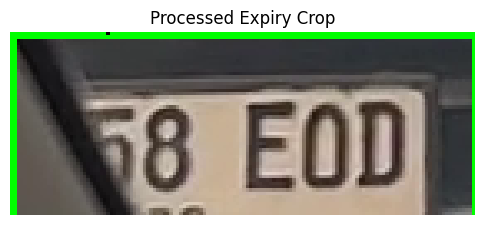

expiration date - 78EOD


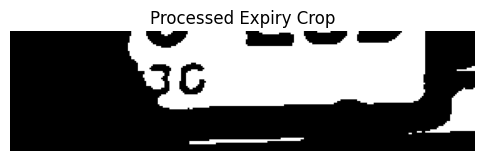

expiration date - UNKNOWN


In [34]:
# --- VIDEO PROCESSING LOOP ---

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, stream=True)

    for result in results:
        boxes = result.boxes
        for box in boxes:
            if int(box.cls[0]) == 2:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                
                plate_text = "..."
                expiry_text = "EMPTY"
                
                try:
                    box_height = y2 - y1
                    split_point_upper = y1 + int(box_height * 0.70)
                    split_point_lower = y1 + int(box_height * 0.55)
                
                    plate_crop = frame[y1:split_point_upper, x1:x2]
                    expiry_crop = frame[split_point_lower:y2, x1:x2]
                    
                    plate_text_results = reader.readtext(preprocess_expiry_crop(plate_crop), detail=0, paragraph=False)
                    plate_text = "".join(plate_text_results).upper().replace(" ", "") if plate_text_results else "..."

                    processed_expiry = preprocess_expiry_crop(expiry_crop)
                    # processed_expiry = expiry_crop
                    
                    if processed_expiry is not None:
                        ocr_results = reader.readtext(
                            processed_expiry,
                            detail=0,
                            paragraph=False,
                            allowlist='0123456789.' # Force OCR to only read digits and dots
                        )
                        raw_text = "".join(ocr_results) if ocr_results else ""
                        
                        if raw_text :
                            expiry_text = raw_text
                        else :
                            expiry_text = "EMPTY"
                        
                        print("--------------------------------------------------------------------------------------")
                        
                        expiry_text = extract_and_validate_date(raw_text)
                
                except Exception as e:
                    plate_text = "ERROR"
                    expiry_text = "ERROR"
                    # print(f"Error: {e}") # Uncomment for debugging

                """show_image(plate_crop, title="Processed Expiry Crop")
                print(f'expiration date - {plate_text}')
                show_image(processed_expiry, title="Processed Expiry Crop")
                print(f'expiration date - {expiry_text}')"""
                
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                display_text_plate = f"Plate: {plate_text}"
                display_text_expiry = f"Expires: {expiry_text}"
                
                (w_plate, h_plate), _ = cv2.getTextSize(display_text_plate, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                (w_expiry, h_expiry), _ = cv2.getTextSize(display_text_expiry, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                max_w = max(w_plate, w_expiry)
                cv2.rectangle(frame, (x1, y1 - (h_plate + h_expiry) - 20), (x1 + max_w + 10, y1), (0, 255, 0), -1)

                cv2.putText(frame, display_text_plate, (x1 + 5, y1 - h_expiry - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
                cv2.putText(frame, display_text_expiry, (x1 + 5, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

    out.write(frame)
    # cv2.imshow('License Plate Recognition', frame) 
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# Debug
show_image(plate_crop, title="Processed Expiry Crop")
print(f'expiration date - {plate_text}')
show_image(processed_expiry, title="Processed Expiry Crop")
print(f'expiration date - {expiry_text}')

# --- CLEAN UP ---
cap.release()
out.release()
cv2.destroyAllWindows()

Now the model separated into 2 picture, the model read the plate and the plate separately